In [4]:
import numpy as np
import matplotlib.pyplot as plt
import pickle
import os
import sys
import warnings
warnings.filterwarnings('ignore')
import time
from itertools import permutations, combinations, product, islice
import pandas as pd
import networkx as nx
from collections import ChainMap
from core_enum import fl
import multiprocess
num_cpus = int(multiprocess.cpu_count()*1)
print('num_cpus = %s'%num_cpus)


## LOAD
extension = '268533'
df = pd.read_pickle('data/df_rpte_%s_branch'%extension)
df.index = df['target'].values


## RUN: sweep eR_thres
def gen_df_gpn(eR_thres):
    '''11s each'''
    tar_list = df[df['eR']>=eR_thres]['target'].values
    tar_all_list = sorted(set(fl(df.loc[tar_list, 'branch']))) # 4492
    # tar_conn_list = [x for x in tar_all_list if x not in tar_list] # 262 (5.8%)

    # df
    df_gpn = df.loc[tar_all_list][['target','source','eR']]
    df_gpn['is_conn'] = df_gpn['eR'].values<eR_thres
    return df_gpn

# eR_thres = .25#0.277911
# df_gpn, tar_all_list, tar_conn_list = gen_df_gpn(eR_thres)

# mp
eR_thres_list = np.sort(np.linspace(.25,.304,55).tolist() + df['eR'][:2].values.tolist() + [df[df['progsize']==3]['eR'].max()] + [df[df['progsize']==4]['eR'].max()] + [df[df['progsize']==5]['eR'].max()])
with multiprocess.Pool(num_cpus) as pool:
    df_gpn_list = pool.map(gen_df_gpn, eR_thres_list)


## prep
n_gpn_list, n_conn_list, ratio_list = [], [], []
for dff in df_gpn_list:
    n_gpn = len(dff)
    n_conn = len(dff[dff['is_conn']])
    ratio = n_conn/n_gpn
    #
    n_gpn_list.append(n_gpn)
    n_conn_list.append(n_conn)
    ratio_list.append(ratio)

num_cpus = 16


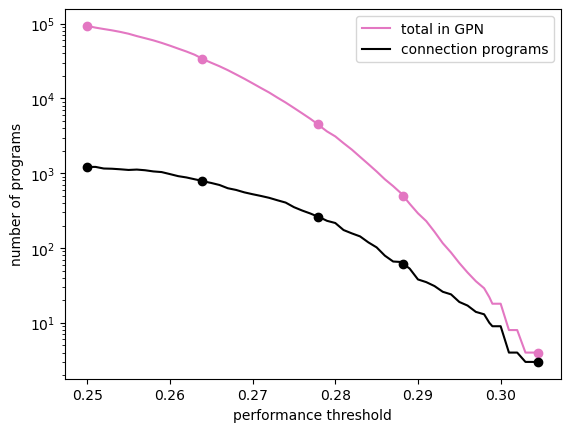

In [5]:
## PLOT: n_prog vs eR_thres
plt.semilogy(eR_thres_list, n_gpn_list, label='total in GPN', color='tab:pink')
plt.semilogy(eR_thres_list, n_conn_list, label='connection programs', color='k')
plt.semilogy(eR_thres_list[[0, 14, 29, 41, -1]], np.array(n_gpn_list)[[0, 14, 29, 41, -1]], marker='o', linestyle='none', color='tab:pink')
plt.semilogy(eR_thres_list[[0, 14, 29, 41, -1]], np.array(n_conn_list)[[0, 14, 29, 41, -1]], marker='o', linestyle='none', color='k')
plt.xlabel('performance threshold')
plt.ylabel('number of programs')
plt.legend()
plt.savefig('fig/resub_eR_thres.pdf',dpi=300)

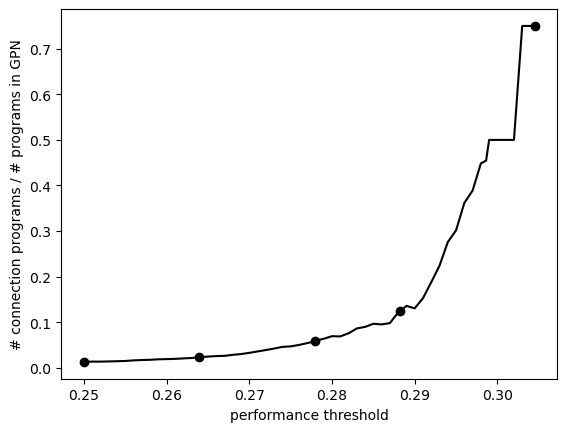

In [6]:
## PLOT: ratio vs eR_thres
plt.plot(eR_thres_list, ratio_list, label='ratio', color='k')
plt.plot(eR_thres_list[[0, 14, 29, 41, -1]], np.array(ratio_list)[[0, 14, 29, 41, -1]], marker='o', linestyle='none', color='k')
plt.xlabel('performance threshold')
plt.ylabel('# connection programs / # programs in GPN')
plt.savefig('fig/resub_eR_thres_ratio.pdf',dpi=300)

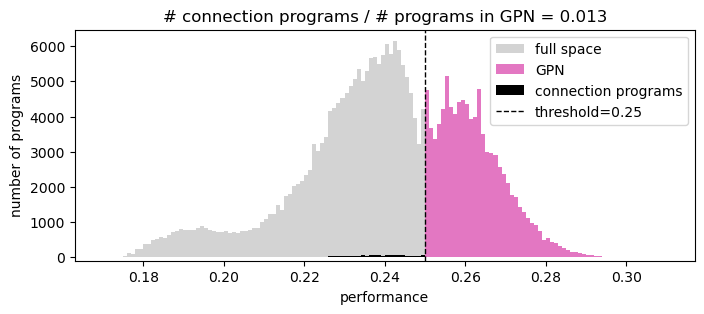

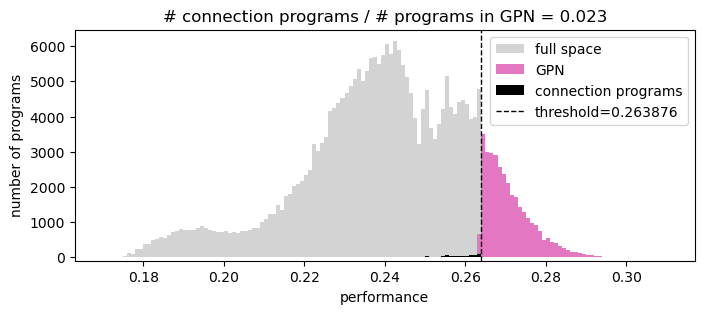

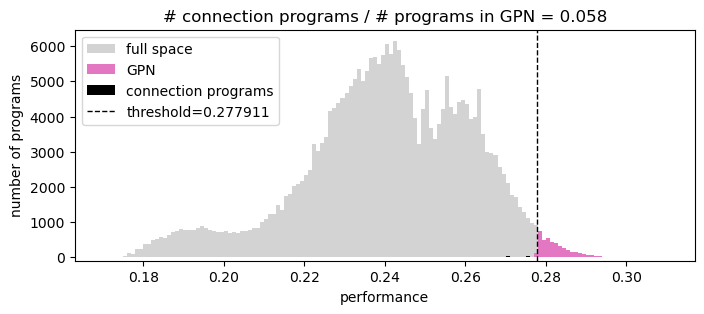

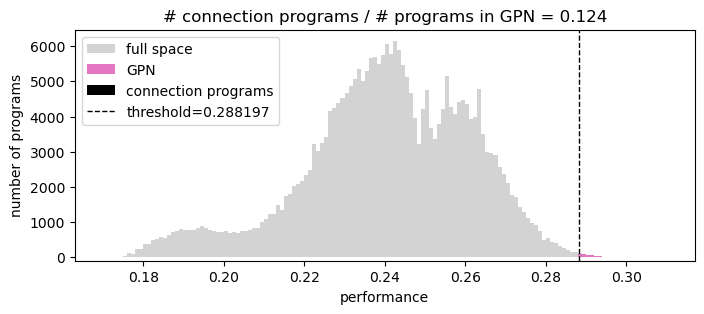

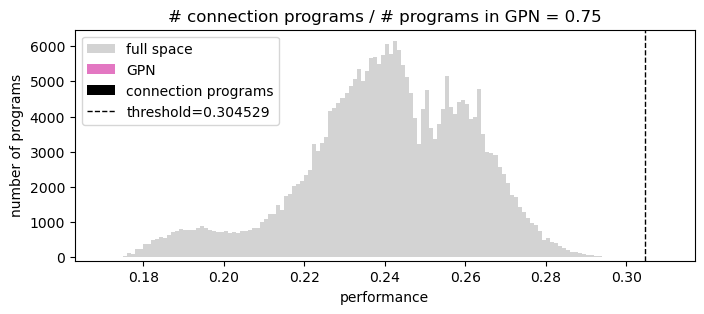

In [7]:
## plot: hist of good/connection program coverage
for idx in [0, 14, 29, 41, -1]:
    eR_thres = eR_thres_list[idx]
    ratio = np.around(ratio_list[idx], 3)
    dff = df_gpn_list[idx]
    dff_conn = dff[dff['is_conn']]
    #
    bins = np.linspace(.17,.31,141)
    plt.figure(figsize=(8,3), dpi=100)
    plt.title('# connection programs / # programs in GPN = %s'%ratio)
    plt.hist(df['eR'].values, bins=bins, label='full space', color='lightgray')
    plt.hist(dff['eR'].values, bins=bins, label='GPN', color='tab:pink')
    plt.hist(dff_conn['eR'].values, bins=bins, label='connection programs', color='k')
    plt.axvline(eR_thres, color='k', ls='--', label='threshold=%s'%eR_thres, lw=1)
    plt.ylim([-100,None])
    plt.xlabel('performance')
    plt.ylabel('number of programs')
    plt.legend()
    plt.savefig('fig/resub_eR_thres_hist_%s.pdf'%idx,dpi=300)

In [408]:
import numpy as np
import matplotlib.pyplot as plt
import pickle
import os
import sys
import warnings
warnings.filterwarnings('ignore')
import time
from itertools import permutations, combinations, product, islice
import pandas as pd


## LOAD
df = pd.read_pickle('data/df_enumP_para14_tsne')
df_pte = pd.read_pickle('data/df_pte_5108')
# tsne_x, tsne_y = df['tsne_x'].values, df['tsne_y'].values

# iDB = df[df['eR']==df['eR'].max()].index[0]
# tsne_xDB, tsne_yDB = df.loc[iDB, ['tsne_x', 'tsne_y']].values
# tsne_xWSLG, tsne_yWSLG = df.loc[4, ['tsne_x', 'tsne_y']].values

eR_list = df['eR'].values
eR_max = eR_list.max()
eR_min = .25 - (eR_list.max()-.25)

# xWSLG = df.loc[4, 'struc_mat']
# xDB = df.loc[iDB, 'struc_mat']
# d_list = [np.abs(x-xDB).sum() for x in df['struc_mat'].values]

In [439]:
struc_tensor_wgtd = np.stack(df['struc_mat'].values) * np.arange(5)[None,None,None]
wiring_d = struc_tensor_wgtd.sum(axis=(1,2,3))
wiring_d_norm = wiring_d/df['progsize'].values**2

# df
df['wiring_d'] = wiring_d
df['wiring_d_norm'] = wiring_d_norm
df['id_unique'] = df.index.values
#
df_1 = df.sort_values(['progsize', 'wiring_d_norm', 'eR'], ascending=[True, True, False])
df_1.index = range(len(df_1))
df_1['eR'] = df_1['wiring_d_norm'].values
df_2 = df_1[['program', 'progsize', 'eR', 't_iter', 'd2enumDB', 'id_unique']]
df_2.to_pickle('data/df_enumP_para14_alt')

In [489]:
# struc_tensor_wgtd = np.stack(df['struc_mat'].values) * np.arange(5)[None,None,None]
# wiring_d = struc_tensor_wgtd.sum(axis=(1,2,3))
# wiring_d_norm = wiring_d/df['progsize'].values**2

# # df
# df['wiring_d'] = wiring_d
# df['wiring_d_norm'] = wiring_d_norm
# df['id_unique'] = df.index.values
# #
# df_1 = df.sort_values(['progsize', 'wiring_d_norm', 'eR'], ascending=[True, True, False])
# df_1.index = range(len(df_1))
# df_1['eR'] = df_1['wiring_d_norm'].values
# df_2 = df_1[['program', 'progsize', 'eR', 't_iter', 'd2enumDB', 'id_unique']]
# df_2.to_pickle('data/df_enumP_para14_alt')

In [515]:
struc_tensor_wgtd = np.stack(df['struc_mat'].values) * np.arange(5)[None,None,None]
wiring_d = struc_tensor_wgtd.sum(axis=(1,2,3))
wiring_d_norm = wiring_d/df['progsize'].values**2

# df
df['wiring_d'] = wiring_d
df['wiring_d_norm'] = wiring_d_norm
df['id_unique'] = df.index.values

# v1
# df_1 = df.sort_values(['progsize', 'wiring_d_norm', 'eR'], ascending=[True, True, False])

# v2
# np.random.seed(42)
# idx_shuffled = np.arange(len(df)) #np.random.permutation(len(df))
# df_1 = df.loc[idx_shuffled].sort_values(['progsize', 'wiring_d_norm'], ascending=[True, True])

# v3
df_1 = df.sort_values(['progsize', 'wiring_d_norm'], ascending=[True, True])

# df
df_1.index = range(len(df_1))
df_1['eR'] = df_1['wiring_d_norm'].values
df_2 = df_1[['program', 'progsize', 'eR', 't_iter', 'd2enumDB', 'id_unique']]
df_2.to_pickle('data/df_enumP_para14_alt_rand')

In [487]:
df_alt_5108 = pd.read_pickle('data/df_pte_5108_alt')
eR_mean, eR_std = df_alt_5108['eR'].values.mean(), df_alt_5108['eR'].values.std()
df_alt_5108['eR_clip'] = np.clip(df_alt_5108['eR'].values, eR_mean-2*eR_std, eR_mean+2*eR_std)
df_alt_5108.to_pickle('data/df_pte_5108_alt')
df_alt_5108[['target', 'source', 'd_hist', 'eR', 'eR_source', 'progsize',
       'd2enumDB', 'id_unique', 'num_outedge', 'id', 'eR_clip']].to_csv('gephi/df_pte_5108_alt.csv', index=False)

(array([0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        6.08236264e-05, 0.00000000e+00, 2.43294506e-04, 4.86589011e-04,
        3.95353571e-04, 1.33811978e-03, 2.25047418e-03, 4.34888929e-03,
        7.22280563e-03, 1.28794029e-02, 3.29207878e-02, 9.30601484e-03,
        6.90652278e-02, 8.91218186e-02, 1.07019171e-01, 1.93069396e-01,
        2.24347946e-01, 3.30774086e-01, 3.26075461e-01, 3.76498247e-01,
        4.37838874e-01, 3.71313033e-01, 3.76376600e-01, 3.61261929e-01,
        2.06739506e-01, 2.21626089e-01, 5.56536181e-02, 1.50903417e-01,
        3.01685187e-02, 2.78268091e-02, 3.57642923e-02, 6.17359808e-03,
        9.21477940e-03, 1.00358984e-03, 3.45174080e-03, 9.12354396e-05,
        2.73706319e-04, 2.28088599e-04, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00]),
 array([-6.        , -5.75510204, -5.51020408, -5.26530612, -5.02040816,
        -4.7755102 , -4.53061224, -4.

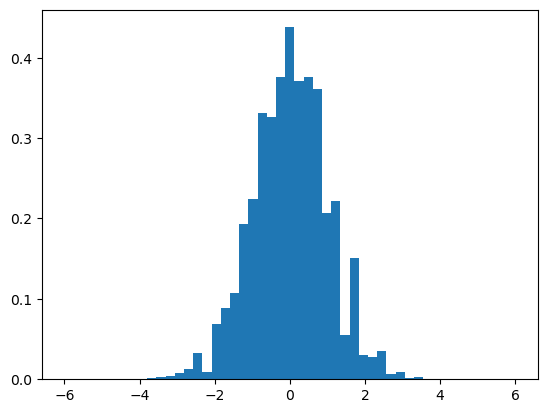

In [662]:
df_alt = pd.read_pickle('data/df_pte_268536_alt')
deR = df_alt['eR'].values - df_alt['eR_source'].values
zscores = (deR-deR.mean()) / deR.std()
plt.hist(zscores, bins=np.linspace(-6,6,50), density=True)

In [162]:
# # clip
# d_mean = wiring_d_norm[:5108].mean()
# d_std = wiring_d_norm[:5108].std()
# df['wiring_d_norm_clip'] = np.clip(wiring_d_norm, d_mean-d_std*2, d_mean+d_std*2)
# #
# eRs = df['eR'].values
# eR_mean = eRs[:5108].mean()
# eR_std = eRs[:5108].std()
# df['eR_clip'] = np.clip(eRs, eR_mean-eR_std*2, eR_mean+eR_std*2)
# #
# uni_5108 = df_pte['id_unique'].values
# dff = df.loc[uni_5108]
# dff[['wiring_d','wiring_d_norm','wiring_d_norm_clip','eR_clip']].to_csv('gephi/%s.csv'%'df_resub', index=False)
# # df[:5108][['eR_clip']].to_csv('gephi/%s.csv'%'df_resub', index=False)

<Axes: >

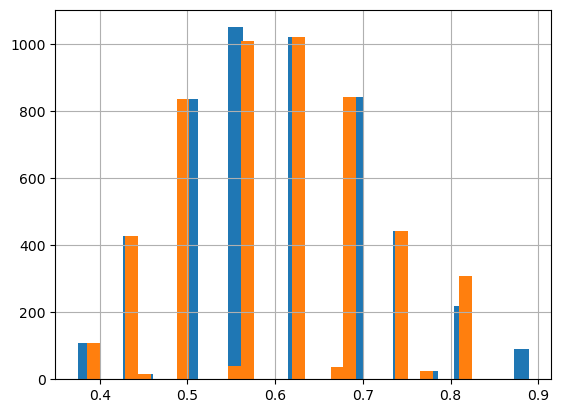

In [164]:
# # dff['eR'].hist(bins=30)
# # dff['eR_clip'].hist(bins=30)
# dff['wiring_d_norm'].hist(bins=30)
# dff['wiring_d_norm_clip'].hist(bins=30)

Text(0, 0.5, 'eR')

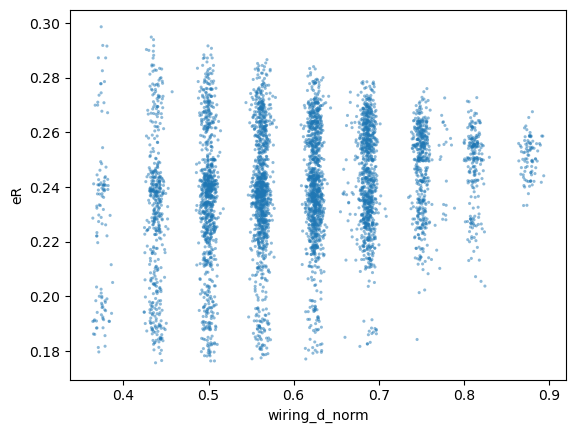

In [64]:
# xx, yy = df['progsize'].values[:5108], wiring_d[:5108]
# rr = df['eR'].values[:5108]
# # plt.scatter(xx, yy/xx**2, alpha=.1)
# plt.scatter(yy/xx**2 + np.random.randn(len(yy))*.005, rr, alpha=.5, edgecolors='none', s=5)
# plt.xlabel('wiring_d_norm')
# plt.ylabel('eR')

(array([ 47.,  92., 120.,  92.,  73., 101., 203., 305., 514., 612., 733.,
        395., 459., 473., 433., 265., 122.,  47.,  19.,   3.]),
 array([0.175687 , 0.1818343, 0.1879816, 0.1941289, 0.2002762, 0.2064235,
        0.2125708, 0.2187181, 0.2248654, 0.2310127, 0.23716  , 0.2433073,
        0.2494546, 0.2556019, 0.2617492, 0.2678965, 0.2740438, 0.2801911,
        0.2863384, 0.2924857, 0.298633 ]),
 <BarContainer object of 20 artists>)

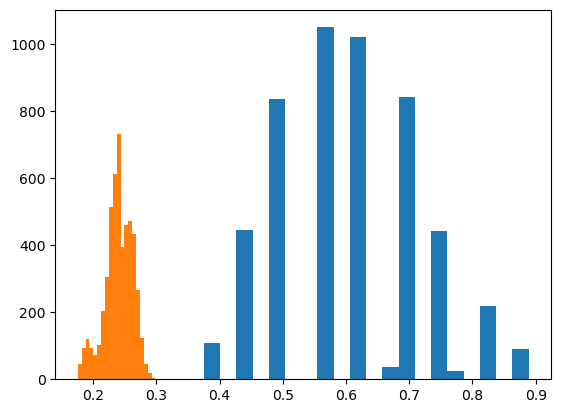

In [69]:
# plt.hist(yy/xx**2, bins=20)
# plt.hist(rr, bins=20)

In [663]:
df_pte = pd.read_pickle('data/df_pte_268533')
dff = df.loc[[3,4] + np.arange(5,268536).tolist()]

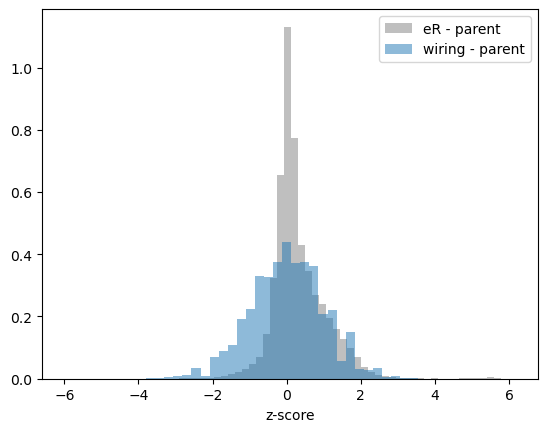

In [692]:
eR_std = df_pte['eR'].values.std()
dnorm_std = dff['wiring_d_norm'].values.std()

deR = (df_pte.loc[df_pte['source'].values, 'eR'] - df_pte['eR'].values) / eR_std
ddnorm = (df.loc[df_pte['source'].values, 'wiring_d_norm'] - dff['wiring_d_norm'].values) / dnorm_std

plt.hist(deR, bins=50, alpha=.5, density=True, label='eR - parent', color='gray')
plt.hist(zscores, bins=np.linspace(-6,6,50), alpha=.5, density=True, label='wiring - parent', color='tab:blue')
plt.xlabel('z-score')
plt.legend()
plt.savefig('fig/resub_er_vs_alt_zscore.pdf', dpi=300)

In [384]:
# df_rpte_wiring = pd.read_pickle('data/df_rpte_268533')
# #
# uni_gpn_wiring = df_gpn_wiring['id_unique'].values
# uni_gpn_conn_wiring = df_gpn_wiring[df_gpn_wiring['wiring_d_norm']>wiring_d_norm_thres]['id_unique'].values
# #
# uni_gpn = df_gpn['id_unique'].values
# uni_gpn_conn = df_gpn[df_gpn['eR']<eR_thres]['id_unique'].values
# #
# df_rpte_wiring['if_wiring_conn'] = [(len(set(x).intersection(set(uni_gpn_conn_wiring)))>0)*1 for x in df_rpte_wiring['unique_ids']]
# df_rpte_wiring['if_wiring_gpn'] = [(len(set(x).intersection(set(uni_gpn_wiring)))>0)*1 for x in df_rpte_wiring['unique_ids']]
# df_rpte_wiring[['id','if_wiring_gpn','if_wiring_conn']].to_csv('gephi/df_rpte_wiring.csv', index=False)

In [667]:
## LOAD
df_rpte = pd.read_pickle('data/df_pte_268536_alt_branch')# pd.read_pickle('data/df_rpte_%s_branch'%extension)
# df_rpte.index = df_rpte['target'].values
# df_rpte['wiring_d_norm'] = dff['wiring_d_norm'].values

## RUN
alt_thres = .37
# (dff['wiring_d_norm']<wiring_d_norm_thres).sum() # 4208 good wiring
tar_list = df_rpte[df_rpte['eR']<alt_thres]['target'].values
tar_all_list = sorted(set(fl(df_rpte.loc[tar_list, 'branch']))) # 4492
tar_conn_list = [x for x in tar_all_list if x not in tar_list] # 262 (5.8%)

## df_rpte
df_gpn_wiring = df_rpte.loc[tar_all_list]

## pickle
df_gpn_wiring.to_csv('gephi/df_gpn_wiring.csv', index=False)


In [678]:
268536-4815

263721

In [676]:
(df_gpn_wiring['eR']<alt_thres).sum(), (df_gpn_wiring['eR']>alt_thres).sum()

(4208, 607)

In [669]:
(df_gpn['eR']>=eR_thres).sum(), (df_gpn['eR']<eR_thres).sum()

(4230, 262)

In [670]:
df_rpte_wiring = pd.read_pickle('data/df_rpte_268536_alt')
#
uni_gpn_wiring = df_gpn_wiring['id_unique'].values
uni_gpn_conn_wiring = df_gpn_wiring[df_gpn_wiring['eR']>alt_thres]['id_unique'].values
#
uni_gpn = df_gpn['id_unique'].values
uni_gpn_conn = df_gpn[df_gpn['eR']<eR_thres]['id_unique'].values
#
df_rpte_wiring['if_wiring_conn'] = [(len(set(x).intersection(set(uni_gpn_conn_wiring)))>0)*1 for x in df_rpte_wiring['unique_ids']]
df_rpte_wiring['if_wiring_gpn'] = [(len(set(x).intersection(set(uni_gpn_wiring)))>0)*1 for x in df_rpte_wiring['unique_ids']]
df_rpte_wiring.to_csv('gephi/df_rpte_wiring.csv', index=False)

In [675]:
df_rpte_wiring[df_rpte_wiring['if_wiring_gpn']!=1]


,id,source,target,part_id,unique_ids,prog_ids,eRs,progsize,eR_mean,eR_std,num_prog,deg,ecc,if_wiring_conn,if_wiring_gpn
1,1,0,1,4,[91],[106],[0.7777777777777778],3,0.777778,0.000000,1,1,3,0,0
8,8,5,8,1,[94],[87],[0.6666666666666666],3,0.666667,0.000000,1,2,4,0,0
9,9,4,9,1,[54],[66],[0.6666666666666666],3,0.666667,0.000000,1,2,5,0,0
14,14,9,14,1,[124],[107],[0.7777777777777778],3,0.777778,0.000000,1,3,3,0,0
16,16,10,16,1,[62],[73],[0.6666666666666666],3,0.666667,0.000000,1,3,4,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5693,5693,5691,5693,3,"[29795, 117577, 233219, 125190, 125379, 125200...","[29655, 141539, 166746, 174505, 175006, 175358...","[0.44, 0.56, 0.6, 0.6, 0.6, 0.6, 0.6, 0.6, 0.6...",5,0.635000,0.067639,24,2,0,0,0
5694,5694,5692,5694,3,"[126491, 132000]","[180130, 211834]","[0.6, 0.64]",5,0.620000,0.020000,2,2,0,0,0
5695,5695,5692,5695,3,"[54791, 34399]","[53634, 83790]","[0.48, 0.52]",5,0.500000,0.020000,2,2,1,0,0
5696,5696,5695,5696,3,"[113121, 126538]","[141634, 179721]","[0.56, 0.6]",5,0.580000,0.020000,2,3,0,0,0


In [185]:
pprog_arr = pickle.load(open('data/df_gpn_pprog_arr', 'rb'))
#
source_0 = pd.read_pickle('data/df_gpn')['source'].values
df_gpn_0 = pd.read_pickle('data/df_gpn_pte')
df_gpn_0['source'] = source_0
df_gpn_0.to_csv('gephi/df_gpn_0.csv', index=False)
#
df_gpn_1 = pd.read_pickle('data/df_gpn_pte')
tar_list = df_gpn_1['target'].values.tolist()

In [215]:
srcs_1, tars_1 = df_gpn_1[['source','target']].values.T
ids_src_1 = np.array([tar_list.index(x) for x in srcs_1])
ids_tar_1 = np.array([tar_list.index(x) for x in tars_1])

In [214]:
srcs_0, tars_0 = df_gpn_0[['source','target']].values.T
ids_src_0 = np.array([tar_list.index(x) for x in srcs_0])
ids_tar_0 = np.array([tar_list.index(x) for x in tars_0])

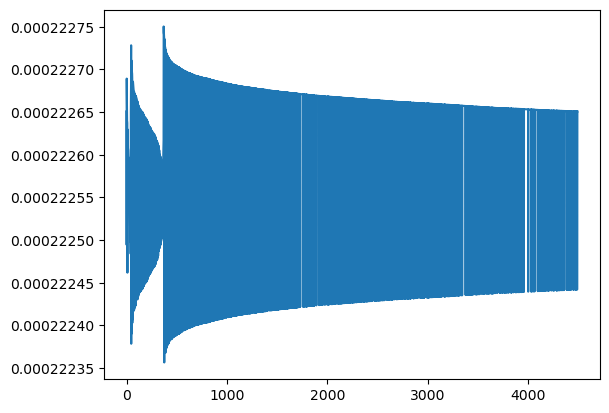

In [259]:
# plt.hist(pprog_arr[42,:,1], bins=np.linspace(0,.004,101))
# plt.hist(pprog_arr[42,:,-1], bins=np.linspace(0,.004,101))
plt.plot(pprog_arr[42,:,0])

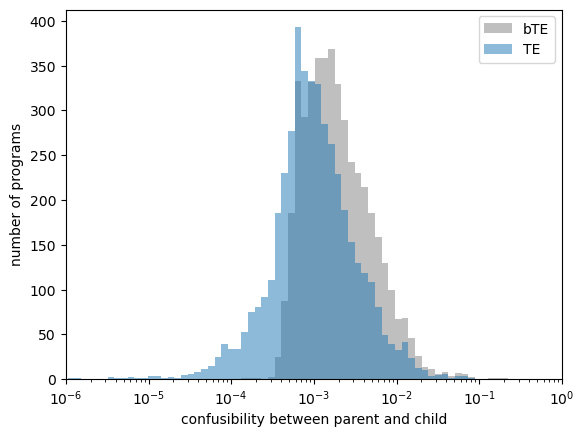

In [693]:
plt.hist(pprog_arr[ids_src_1,ids_tar_1,-1], bins=np.logspace(-8,0,100), alpha=.5, label='bTE', color='gray')
plt.hist(pprog_arr[ids_src_0,ids_tar_0,-1], bins=np.logspace(-8,0,100), alpha=.5, label='TE', color='tab:blue')
plt.xscale('log')
plt.xlabel('confusibility between parent and child')
plt.ylabel('number of programs')
plt.xlim([1e-6,1])
plt.legend()
plt.savefig('fig/resub_bte_vs_te_confusibility.pdf', dpi=300)